# Demonstrating the BOP-DMD

Bagging-Optimized Dynamic Mode Decomposition.

Citations:

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

- **Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)**: Sashidhar, D., & Kutz, J. N. (2022). Bagging, optimized dynamic mode decomposition for robust, stable forecasting with spatial and temporal uncertainty quantification. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2229). https://doi.org/10.1098/rsta.2021.0199

## Details

Both the optDMD and BOP-DMD were previously only matlab implementations. The focus of this notebook is the implementation and testing of crude python translations.

1) optDMD: Provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots. 

2) The BOP-DMD takes advantage of this property and solves the DMD using statistical bagging (i.e., randomly selected ensembles) for constructing the DMD.

The advantage of the combined BOP-DMD is: (a) the additional ability to provide uncertainty estimates in the DMD solutions, especially the uncertainty in the spatial modes, (b) the ability to better represent the time dynamics for more complex systems such as those commonly found in geophysics, and (c) robustly solving the DMD for noisy data.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter

### Quick word on warnings:

The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# A REALLY STUPID workaround until I make this a package.
get_directories = True
if get_directories:
    notebook_dir = os.getcwd()
    package_dir = os.path.join(notebook_dir, '../..')
    sys.path.append(package_dir)
    from py_optDMD.src import *
    get_directories = False

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# "A Simple Example"

The optDMD and the BOP-DMD are both demonstrated using the "Simple Example" from Sashidhar and Kutz (2022). Here data generated from 3 spatial modes are fit. Each mode has time dynamics which are exponential in time.

The specifics of this implementation follow from https://github.com/dsashid/BOP-DMD/blob/main/BOP_DMD_main.m

The results from the python version will be compared to the results from a similar test in matlab.

In [4]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 1
nx = 200

# Space component is evenly spaced originally.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dynamics.
t0 = 0
t1 = 1
nt = 100
ts = np.linspace(t0,t1,nt)[np.newaxis, :]

# Eigenvalues for each mode
e1 = 1 + 0j
e2 = -2 + 0j
e3 = 0 + 1j
true_eigenvalues = np.array([e1, e2, e3])

# Generate the clean, noiseless dynamics.
xclean = f1.dot(np.exp(e1 * ts)) + f2.dot(np.exp(e2 * ts)) + f3.dot(np.exp(e3 * ts))

# optDMD

Here I've finished the implementation of the python version of optDMD. This code has exactly identical versions of the optDMD output for the zero noise case and qualitatively similar outputs for added noise.

Various levels of noise, $\sigma$, are considered here for the optDMD evaluation.

The error is approximately linear with the amount of noise. i.e., a magnitude increase in $\sigma$ corresponds to almost exactly a magnitude increase in the error for this example.

**Notes**:
- The optDMD only returns real eigenvalues when providing real data (e.g., what we would normally provide when data mining). This behavior is consistent with the reference matlab code. The reference matlab code for the BOP-DMD makes reference to the eigenvalue solutions having an imaginary component, making this a confusing conundrum that needs to be resolved. 

- The `imode` keyword is not implemented. In the optDMD manuscript and reference matlab code there are several strategies presented for solving the nonlinear regression inside of the DMD. As the BOP-DMD reference code only uses the strategy `imode=0`, this keyword appears to be no longer necessary. 

(100,)
(100, 1)


ValueError: operands could not be broadcast together with shapes (3,100) (100,3) 

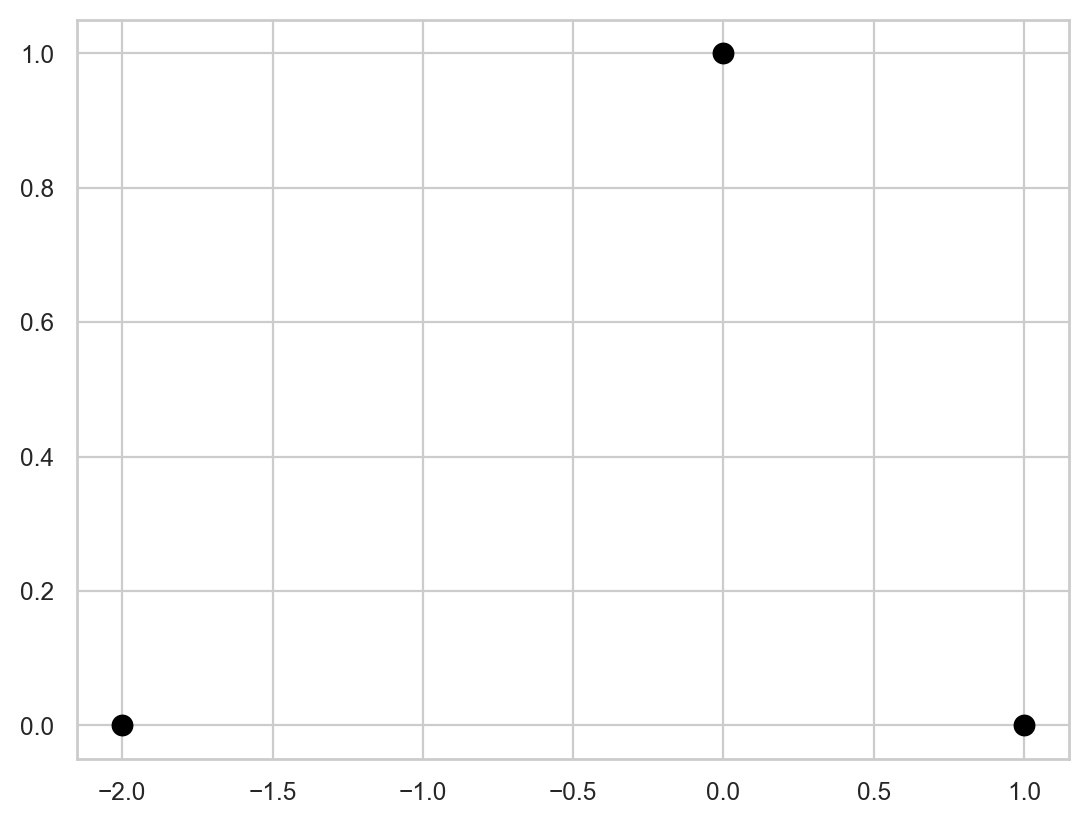

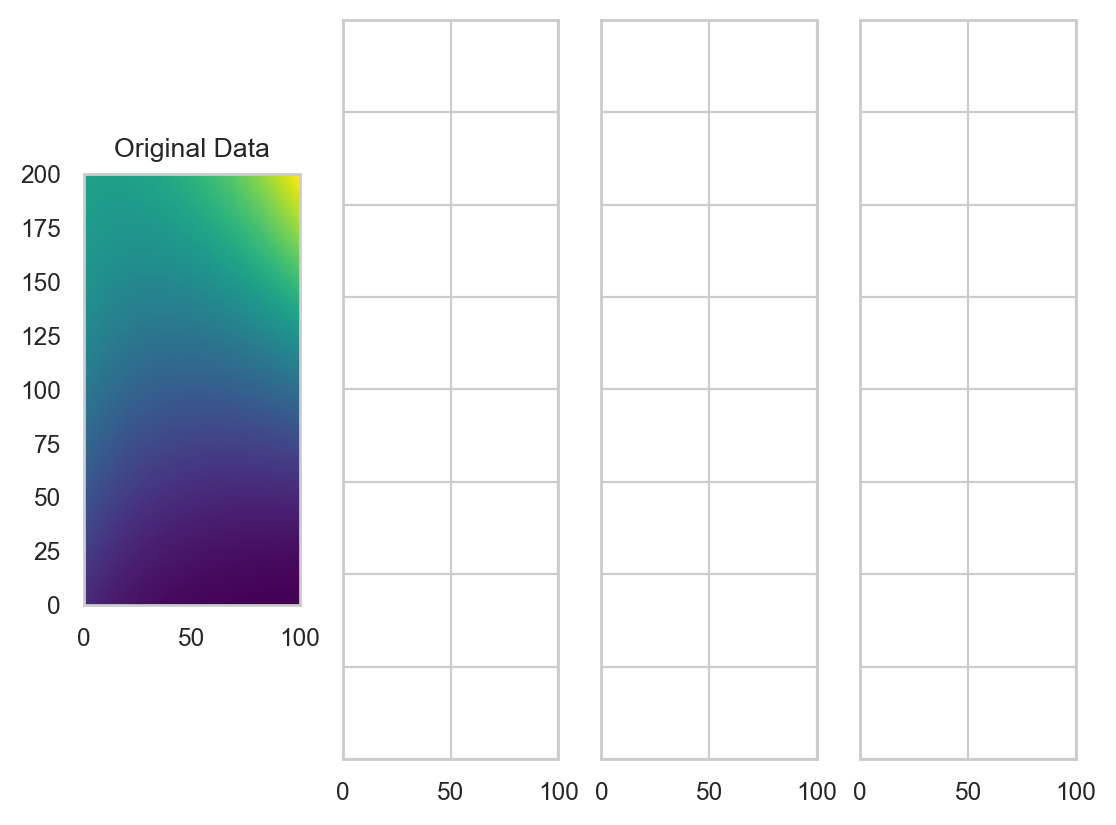

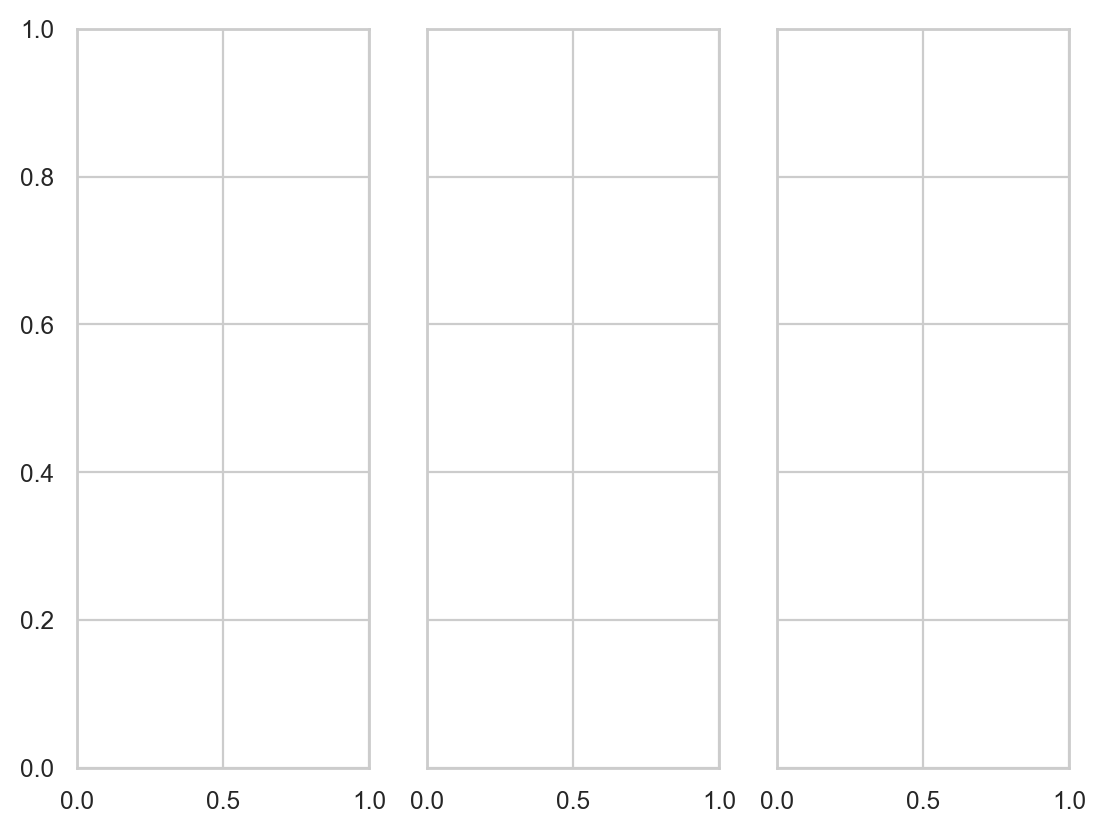

In [5]:
sigma_array = np.array([1e-3, 1e-2, 1e-1])

# Generate figure and axis handles for the evaluation plots
fig_eig_scatter, ax_eig_scatter = plt.subplots(1, 1)
fig_reconstruct, axes_reconstruct = plt.subplots(
    1, len(sigma_array) + 1, sharex=True, sharey=True
)
fig_reconstruct_error, axes_reconstruct_error = plt.subplots(
    1, len(sigma_array), sharex=True, sharey=True)

# Reconstructed data
ax = axes_reconstruct[0]
im = ax.pcolormesh(
    np.abs(xclean ** 2),
    cmap='viridis'
)
ax.set(adjustable='box', aspect='equal')
ax.set_title('Original Data')

# True eigenvalues for the eigenvalue scatter plot.
ax_eig_scatter.scatter(
    np.real(true_eigenvalues),
    np.imag(true_eigenvalues),
    50,
    color='k',
    marker='o',
    label='True Eigenvalues'
)


for nsigma, sigma in enumerate(sigma_array):
    # Add noise to the clean example data.
    # Values greater than about 0.1 lead to the whole thing failing.
    xdata = xclean + sigma * np.random.randn(*xclean.shape)
    
    # Here we specify the number of modes using r = 3.
    r = 3
    # imode (solution method) is not used in the python implementation.
    imode = 0
    
    # Call the optDMD and solve.
    w, e, b = optimalDMD.optdmd(xdata, ts, r, imode, verbose=False)
    
    # Reconstruct the data.
    x1 = np.dot(np.dot(w, np.diag(b)), np.exp(np.dot(e[:, np.newaxis], ts)))

    # Determine the error of the optDMD solution.
    # Note: Numpy performs the Frobenius norm by default.
    relerr_r = np.linalg.norm(x1 - xdata) / np.linalg.norm(xdata)
    relerr_r_clean = np.linalg.norm(x1 - xclean) / np.linalg.norm(xclean);

    # Evaluate the optDMD solution against the actual eigenvalues by matching
    # the optDMD eigenvalues to the true eigenvalues using the Munkres algorithm.
    _, indices = bop_dmd.match_vectors(e, true_eigenvalues)
    relerr_e = (
        np.linalg.norm(e[indices] - true_eigenvalues, 2)
        / np.linalg.norm(true_eigenvalues, 2)
    )
    
    print()
    print('Example 1 results for sigma={}:'.format(sigma))
    print('Relative error in reconstruction {:.4f}'.format(relerr_r))
    print('Relative error w.r.t clean data {:.4f}'.format(relerr_r_clean))
    print('Relative error of eigenvalues {:.4f}'.format(relerr_e))

    # Reconstructed data error
    ax = axes_reconstruct_error[nsigma]
    im = ax.pcolormesh(
        (np.abs(xclean ** 2) - np.abs(x1 ** 2)) / np.abs(xclean ** 2),
        vmax=0.05,
        vmin=-0.05,
        cmap='RdBu_r'
    )
    ax.set(adjustable='box', aspect='equal')
    ax.set_title('sigma={}'.format(sigma))

    # Reconstructed data
    ax = axes_reconstruct[nsigma + 1]
    im = ax.pcolormesh(
        np.abs(x1 ** 2),
        cmap='viridis'
    )
    ax.set(adjustable='box', aspect='equal')
    ax.set_title('sigma={}'.format(sigma))

    # Scatterplot of eigenvalues
    ax_eig_scatter.scatter(
        np.real(e),
        np.imag(e),
        marker='d',
        label='optDMD (sigma={})'.format(sigma)
    )

# cbar = fig_reconstruct.colorbar(im)
# cbar.set_label('% Error')
fig_reconstruct_error.suptitle('Relative error in reconstructed data')
fig_reconstruct_error.tight_layout()

# fig_reconstruct.suptitle('Reconstructed data', y=1.02)
fig_reconstruct.tight_layout()

# Finish formatting the eigenvalues scatter plot.
ax_eig_scatter.legend()
ax_eig_scatter.set_ylabel('Imaginary')
ax_eig_scatter.set_xlabel('Real')
ax_eig_scatter.set_title('Eigenvalues')

# BOP-DMD


## Helper function: build xarray containers for ensemble results

In [13]:
def build_ensemble_xarray(data, ds_previous=None, num_eigenvalues=3, concat_dim='cycle'):
    """Convert the results to an xarray Dataset.
    
    Dataset has coordinates of
    index (a melt of eigenvalue and ensemble member) and cycle (number of
    ensembles created).
    """
    
    # Build the eigenvalues dimension
    eigenvalues_coord = [str(k) for k in np.arange(1, num_eigenvalues + 1)]
    
    # Convert to a Pandas dataframe to use the melt function.
    # Build the real component
    df_real = pd.DataFrame(
        data=data.real,
    )
    df_real['eigenvalue'] = eigenvalues_coord
    df_real = pd.melt(df_real, id_vars='eigenvalue', value_name='real')
    df_real = df_real.drop(columns='variable')

    # Build the imaginary component.
    df_imag = pd.DataFrame(
        data=data.imag,
    )
    df_imag['eigenvalue'] = eigenvalues_coord
    df_imag = pd.melt(df_imag, id_vars='eigenvalue', value_name='imag')
    df_imag = df_imag.drop(columns='variable')

    # Concatenate the real and imaginary components into a single Dataframe.
    df = pd.concat(
        [df_real, df_imag], axis=1
    )

    # Drop the duplicate columns from the melt.
    df = df.loc[:,~df.columns.duplicated()]

    # Convert to xarray since this better handles the multidimensional data.
    ds = xr.Dataset.from_dataframe(df)
    if ds_previous is None:
        ds = ds
    else:
        ds = xr.concat([ds_previous, ds], dim='cycle')
        
    return ds

## Evaluate against varying levels of sigma

sigma=0.1

====================== out of 25 total ensembles.
sigma=0.01

====================== out of 25 total ensembles.
sigma=0.001



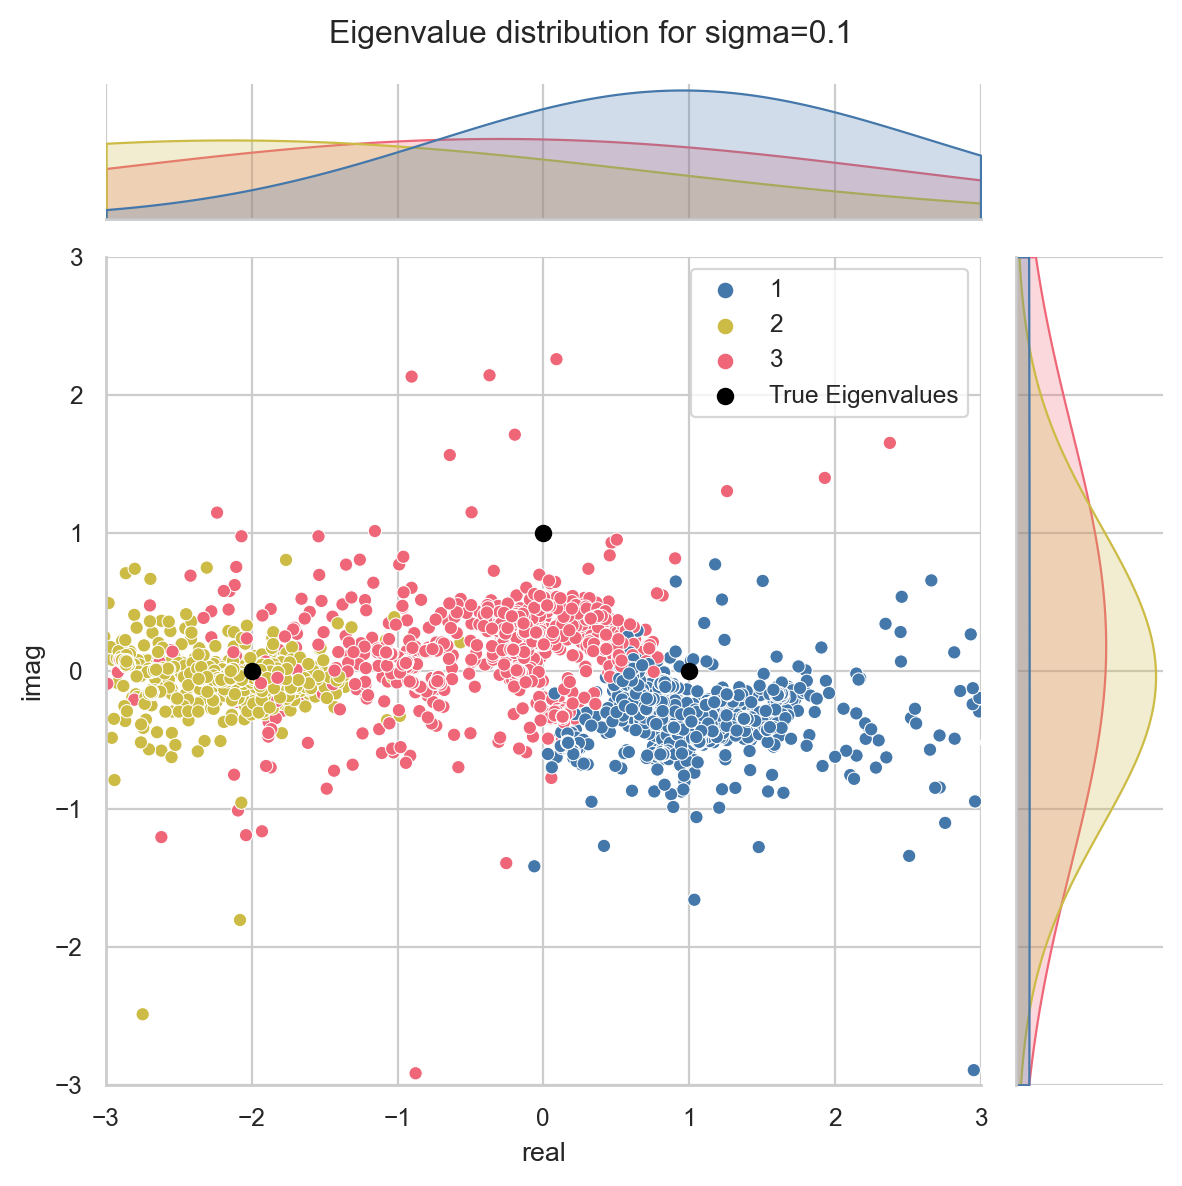

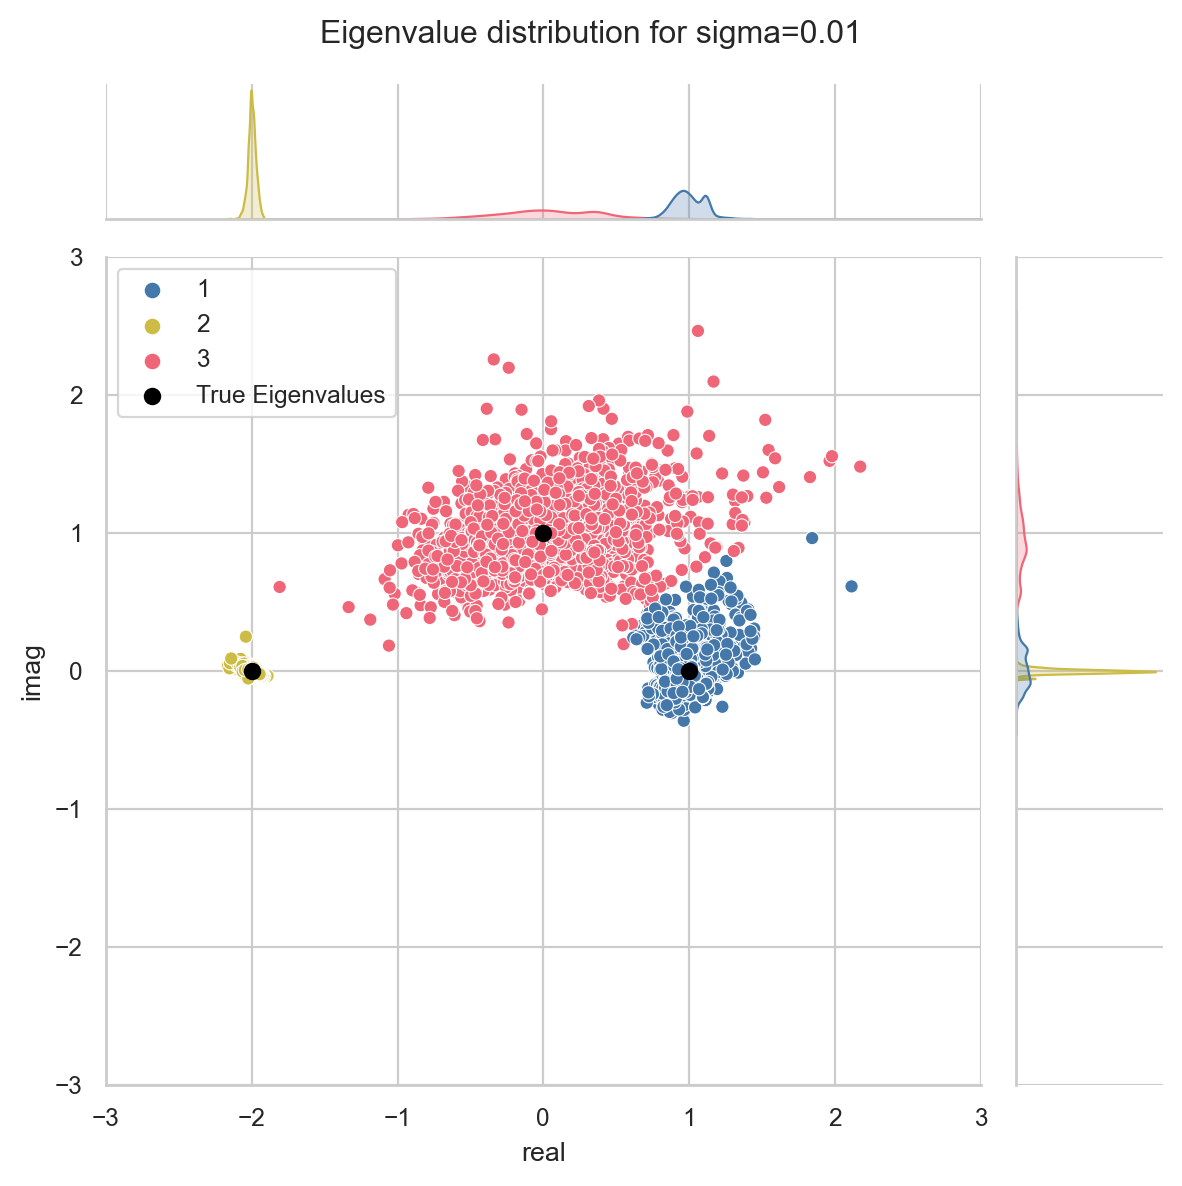

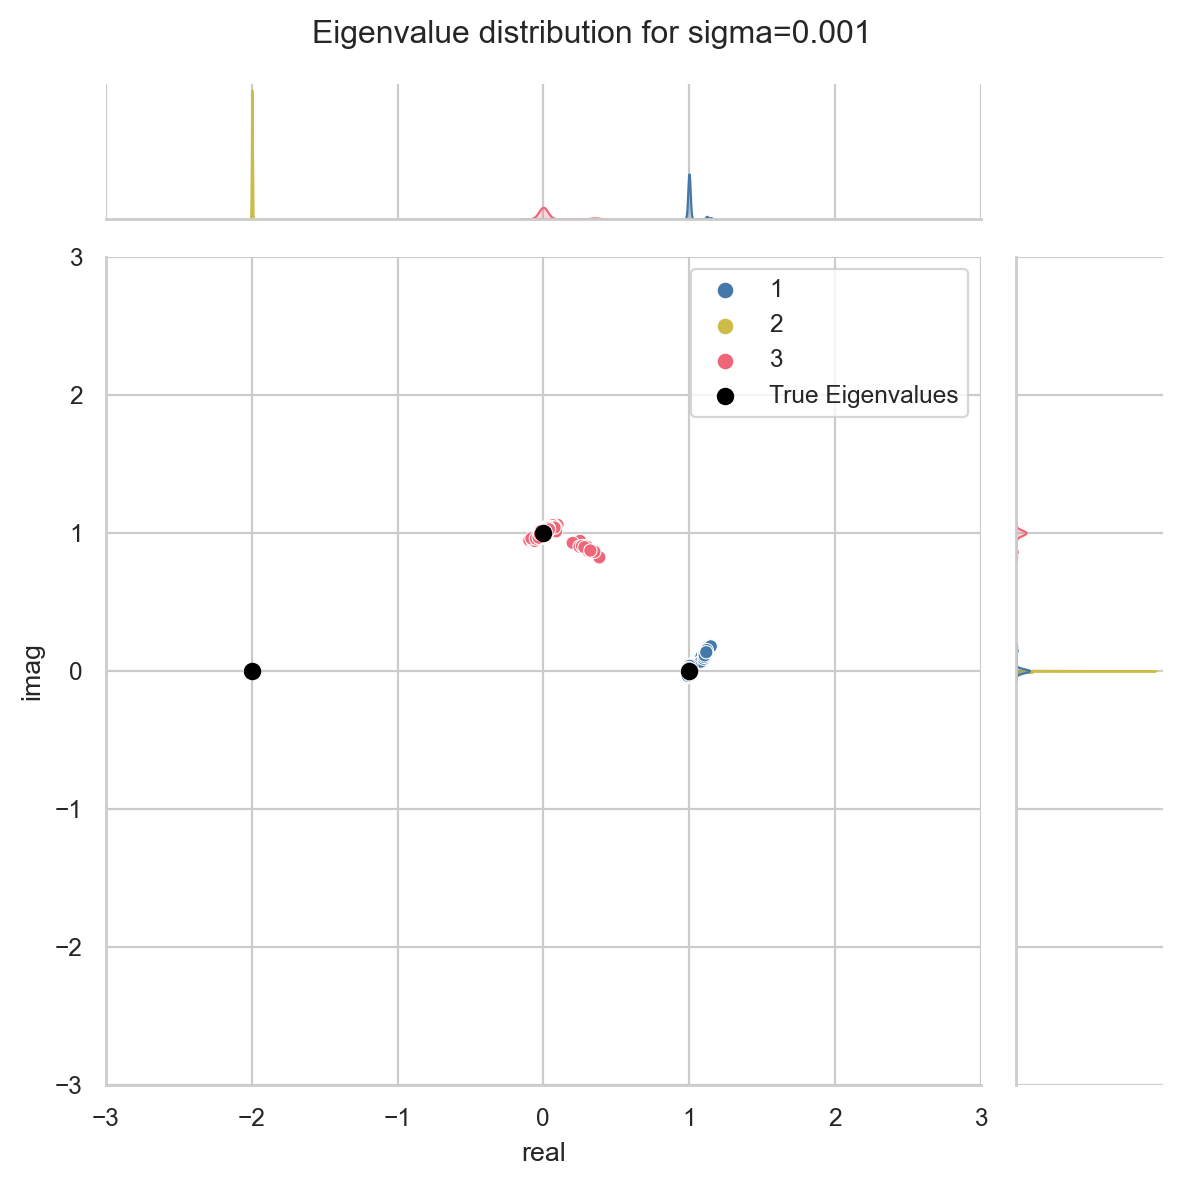

In [7]:
# Set the random seed
rng = np.random.default_rng(1)

# Number of time points
n = len(ts)

# Number you want to choose (for each ensemble member?)
p = 50
# Number of noise cycles
num_noise_cycles = 25
# number of cycles for each noise cycle
num_cycles =  100

sigma_array = [1e-1, 1e-2, 1e-3]

# Create the lambda vector for DMD cycles.
lambda_vec_DMD = np.zeros((3, num_noise_cycles))

# Create the lambda vector for optdmd cycles.
lambda_vec_optDMD = np.zeros((3, num_noise_cycles))

# Create the lambda vector for optdmd cycles (how is this different?)
lambda_vec_mean_ensembleDMD = np.zeros((3, num_cycles))

for sigma in sigma_array:
    print('')
    print('======================')
    print('sigma={}\n'.format(sigma))
    
    ds_all = None
    ds_optdmd = None
    
    for k in range(num_noise_cycles):
        print(
            'Working on ensemble {} out of {} total ensembles.'.format(
                k + 1,
                num_noise_cycles
            ),
            end='\r'
        )
        # Create data for noise cycle (add random noise)
        # sigma = .1
        xdata = xclean + sigma * rng.standard_normal(xclean.shape)

        # Create the lambda vector for ensembleDMD cycle
        lambda_vec_ensembleDMD = np.zeros((3, num_cycles)).astype(complex)

        # Try the DMD -- putting this off until I can figure out how the pydmd and this unknown
        # DMD function relate to each other. Should be straightforward.
        # phi_DMD, lam_DMD, b_DMD, sig_DMD = DMD(xdata(:,1:end-1), xdata(:,2:end), 3);

        # Try the regular optdmd (without bagging)
        w_opt, e_opt, b_opt = optimalDMD.optdmd(xdata, ts, 3, 1)

        for j in range(num_cycles):
            # Try with optdmd using optDMD modes as initial conditions
            # Randomly select time indices.
            ind = rng.integers(low=0, high=ts.size - 1, size=p)

            # Sort the index to be in ascending order. This step generates variable
            # length time steps.
            ind = np.sort(ind)

            # Create the subselected dataset for this cycle using the sorted indices.
            xdata_cycle = xdata[:, ind]
            ts_ind = ts[:, ind]

            # For very high levels of noise the linear least squares svd solver
            # can fail. We catch those instances and pass on to the next ensemble
            # member.
            try:
                # Solve optdmd for this ensemble member.
                w_cycle, e1_cycle, b_cycle = optimalDMD.optdmd(
                    xdata_cycle,ts_ind, 3, 0, alpha_init=e_opt, verbose=False
                )

                # Match the BOP-DMD eigenvalues to the true eigenvalues for comparison using the
                # Munkres algorithm.
                _, indices = bop_dmd.match_vectors(e1_cycle, true_eigenvalues)

                # Assign to the outer container using the correct ordering.
                lambda_vec_ensembleDMD[:, j] = e1_cycle[indices]

            except np.linalg.LinAlgError:
                lambda_vec_ensembleDMD[:, j] = np.complex(np.nan)

        # lambda_vec_DMD[:, k] = diag(lam_DMD)
        lambda_vec_optDMD[:, k] = e_opt

        # Convert the results to an xarray Dataset. Dataset has coordinates of
        # index (a melt of eigenvalue and ensemble member) and cycle (number of
        # ensembles created).

        # Build the real component
        df_real = pd.DataFrame(
            data=lambda_vec_ensembleDMD.real,
        )
        df_real['eigenvalue'] = ['1', '2', '3']
        df_real = pd.melt(df_real, id_vars='eigenvalue', value_name='real')
        df_real = df_real.drop(columns='variable')

        # Build the imaginary component.
        df_imag = pd.DataFrame(
            data=lambda_vec_ensembleDMD.imag,
        )
        df_imag['eigenvalue'] = ['1', '2', '3']
        df_imag = pd.melt(df_imag, id_vars='eigenvalue', value_name='imag')
        df_imag = df_imag.drop(columns='variable')

        # Concatenate the real and imaginary components into a single Dataframe.
        df = pd.concat(
            [df_real, df_imag], axis=1
        )

        # Drop the duplicate columns from the melt.
        df = df.loc[:,~df.columns.duplicated()]

        # Convert to xarray since this is easier to investigate.
        ds = xr.Dataset.from_dataframe(df)
        if ds_all is None:
            ds_all = ds
        else:
            ds_all = xr.concat([ds_all, ds], dim='cycle')

    # Distribution of eigenvalues
    if sigma > 0.05:
        xlims = (-5, 5)
        ylims = (-5, 5)
    else:
        xlims = (-3, 3)
        ylims = (-3, 3)

    g = sns.jointplot(
        data=ds_all.to_dataframe(),
        x="real",
        y="imag",
        hue='eigenvalue',
        marginal_kws={'clip': xlims}
    )

    g.ax_joint.set_xlim(xlims)
    g.ax_joint.set_ylim(ylims)
    g.ax_joint.scatter(
        np.real(true_eigenvalues),
        np.imag(true_eigenvalues),
        30,
        color='k',
        marker='o',
        label='True Eigenvalues'
    )
    g.ax_joint.legend()
    g.fig.suptitle("Eigenvalue distribution for sigma={}".format(sigma))
    g.fig.tight_layout()

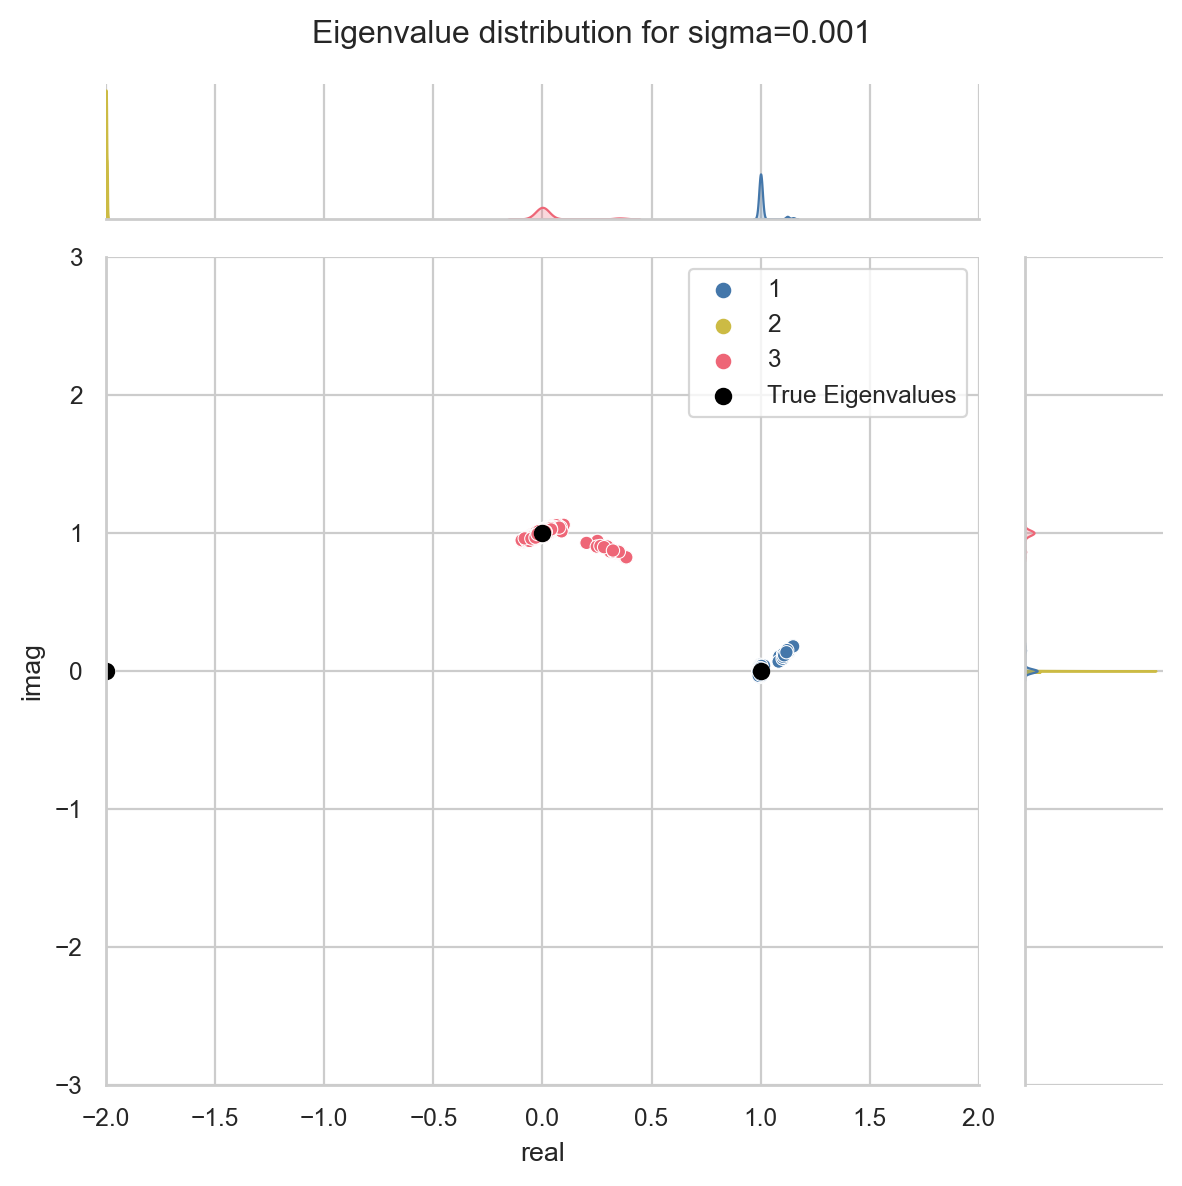